In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




In [4]:
# Read the dataset
df = pd.read_csv('/home/hemanth/Downloads/italy_earthquakes_from_2016-08-24_to_2016-11-30.csv').set_index('Time')
df.index = pd.to_datetime(df.index)
df.head()



,Latitude,Longitude,Depth/Km,Magnitude
Time,,,,
2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6


In [5]:
# Compute summary statistics
df.describe()

,Latitude,Longitude,Depth/Km,Magnitude
count,8086.000000,8086.000000,8086.000000,8086.000000
mean,42.829557,13.161034,9.968328,2.398368
std,0.125927,0.083058,2.194064,0.426381
min,41.581300,12.537700,0.200000,2.000000
25%,42.751350,13.103200,8.900000,2.100000
50%,42.821800,13.160700,9.900000,2.300000
75%,42.911000,13.215650,10.800000,2.600000
max,43.927300,13.852500,47.900000,6.500000


### Magnitude

Text(0, 0.5, 'Magnitude')

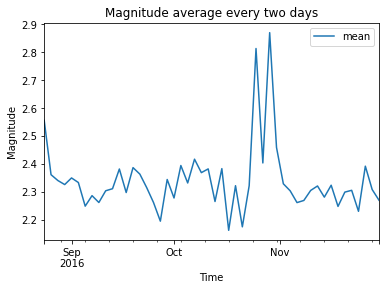

In [6]:
df["Magnitude"].resample("2D").apply([np.mean]).plot()
plt.title("Magnitude average every two days")
plt.ylabel("Magnitude")


Text(0, 0.5, 'Magnitude')

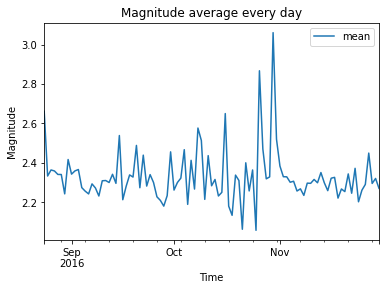

In [7]:
df["Magnitude"].resample("D").apply([np.mean]).plot()
plt.title("Magnitude average every day")
plt.ylabel("Magnitude")

### Magnitude Rolling Mean

In [10]:
# Pandas series with magnitudes greater than 3.0
magn3 = df.loc[df["Magnitude"] >= 3.0, "Magnitude"]


Text(0, 0.5, 'Magnitude')

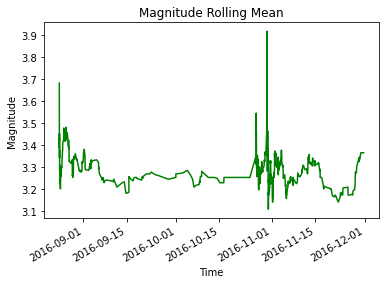

In [11]:
pd.Series.rolling(magn3, window=25).mean().plot(style="-g")
plt.title("Magnitude Rolling Mean")
plt.ylabel("Magnitude")


### Depth

Text(0.5, 0, 'Depth/Km')

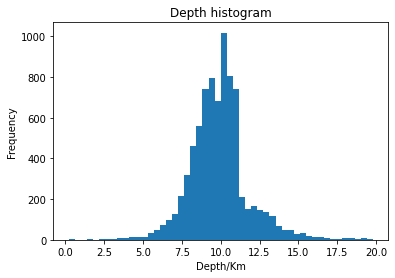

In [12]:
plt.figure()

depth = df[(df["Depth/Km"] < 20) & (df["Depth/Km"] >= 0)]["Depth/Km"]
depth.plot(kind="hist", stacked=True, bins=50)

plt.title("Depth histogram")
plt.xlabel("Depth/Km")

Text(0.5, 1.0, 'Magnitude and Depth during the day')

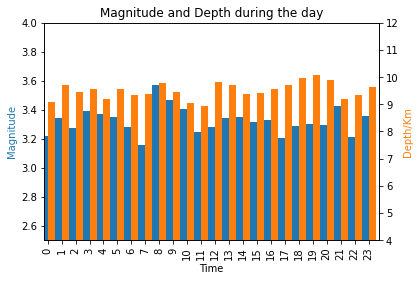

In [13]:
depth_magn = df.where((df["Magnitude"] >= 3.0)).dropna()[["Magnitude", "Depth/Km"]]
dm = depth_magn.groupby(depth_magn.index.hour).mean()

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_ylim([2.5, 4.0])
ax.set_ylabel("Magnitude")
ax.set_xlabel("Hour of the day")
ax.yaxis.label.set_color("#1f77b4")

ax2 = ax.twinx()
ax2.set_ylim([4.0, 12])
ax2.set_ylabel("Depth/Km")
ax2.set_xlabel("Hour of the day")
ax2.yaxis.label.set_color("#ff7f0e")

width = 0.5

dm["Magnitude"].plot(kind="bar", color='#1f77b4', ax=ax, width=width, position=1)
dm["Depth/Km"].plot(kind="bar", color="#ff7f0e", ax=ax2, width=width, position=0)

plt.grid(False)
plt.title("Magnitude and Depth during the day")



In [14]:
# This function is taken from here:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t


In [17]:
n_predict = 300
resample_period = "2D"
predict_period = "D"

pred = pd.Series(
    fourierExtrapolation(magn3, n_predict),
    index=magn3.index.append(pd.DatetimeIndex(start="2016-12-01", freq="45T", periods=n_predict))
                )

fig = plt.figure()

fitted = pred[:-n_predict].resample(resample_period).mean()
predict = pred[-n_predict:].resample(predict_period).mean()

fitted.plot(linewidth=3, label="extrapolation")
predict.plot(linewidth=3, style="-g", label="prediction")
magn3.resample(resample_period).mean().plot(label="data")

plt.title("Magnitude forecasting")
plt.ylabel("Magnitude")
plt.legend(loc="lower left")



TypeError: __new__() got an unexpected keyword argument 'start'